#  Chapter 4, demo 1

Bayesian Data Analysis, 3rd ed

Normal approximation for Bioassay model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import preliz as pz
from scipy.optimize import minimize
pz.style.use('preliz-doc')

In [2]:
# Bioassay data, (BDA3 page 86)
x = np.array([-0.86, -0.30, -0.05, 0.73])
n = np.array([5, 5, 5, 5])
y = np.array([0, 1, 3, 5])

Compute the posterior density in grid
 * usually should be computed in logarithms!
 * with alternative prior, check that range and spacing of A and B are sensible

In [3]:
ngrid = 100
A = np.linspace(-4, 8, ngrid)
B = np.linspace(-10, 40, ngrid)
ilogit_abx = 1 / (np.exp(-(A[:,None] + B[:,None,None] * x)) + 1)
p = np.prod(ilogit_abx**y * (1 - ilogit_abx)**(n - y), axis=2)

The following demonstrates an alternative "bad" way of calcuting the posterior density p in a for loop. The vectorised statement above is numerically more efficient. In this small example however, it would not matter that much.

    p = np.empty((len(B),len(A))) # allocate space
    for i in range(len(A)):
        for j in range(len(B)):
            ilogit_abx_ij = (1 / (np.exp(-(A[i] + B[j] * x)) + 1))
            p[j,i] = np.prod(ilogit_abx_ij**y * ilogit_abx_ij**(n - y))

N.B. the vectorised expression can be made even more efficient, e.g. by optimising memory usage with in-place statements, but it would result in a less readable code.

In [4]:
# sample from the grid
nsamp = 1000
samp_indices = np.unravel_index(
    np.random.choice(p.size, size=nsamp, p=p.ravel()/np.sum(p)),
    p.shape
)
samp_A = A[samp_indices[1]]
samp_B = B[samp_indices[0]]
# add random jitter, see BDA3 p. 76
samp_A += (np.random.rand(nsamp) - 0.5) * (A[1]-A[0])
samp_B += (np.random.rand(nsamp) - 0.5) * (B[1]-B[0])

# samples of LD50
samp_ld50 = - samp_A / samp_B

Find the mode by minimising negative log posterior. Compute gradients and Hessian analytically, and use Newton's method for optimisation. You may use optimisation routines below for checking your results. See help for scipy.optimize.minimize.

In [5]:
# define the optimised function
def bioassayfun(w):
    a = w[0]
    b = w[1]
    et = np.exp(a + b * x)
    z = et / (1 + et)
    e = - np.sum(y * np.log(z) + (n - y) * np.log(1 - z))
    return e
# initial guess
w0 = np.array([0.0, 0.0])
# optimise
optim_res = minimize(bioassayfun, w0)
# extract desired results
w = optim_res['x']
S = optim_res['hess_inv']

Compute the normal approximation density in grid this is just for the illustration

In [6]:
# Create a grid of (A, B) points
AA, BB = np.meshgrid(A, B, indexing='ij')  # shape (ngrid, ngrid)
# Stack into (ngrid, ngrid, 2) for multivariate pdf
grid = np.stack((AA, BB), axis=-1)
# Evaluate multivariate normal pdf
p_norm = pz.MvNormal(mu=w, cov=S).pdf(grid)
# draw samples from the distribution
samp_norm = pz.MvNormal(mu=w, cov=S).rvs(size=1000)

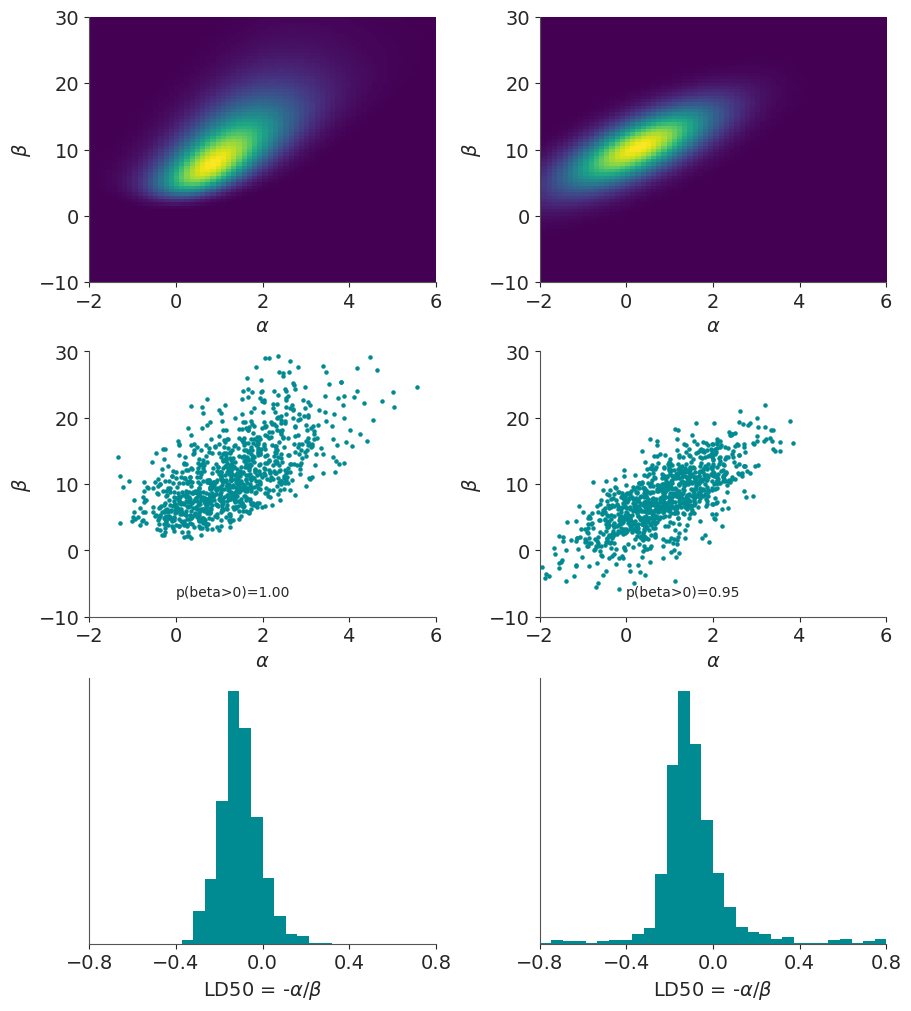

In [7]:
fig, axes = plt.subplots(3, 2, figsize=(9, 10))

# Define common axis limits
xlim, ylim = [-2, 6], [-10, 30]
ld50_bins = np.linspace(-0.8, 0.8, 31)
ld50_xticks = np.linspace(-0.8, 0.8, 5)

bpi = samp_norm[:,1] > 0
samp_ld50_norm = -samp_norm[bpi,0] / samp_norm[bpi,1]

# Posterior densities
for ax, p_ in zip(axes[0], [p, p_norm]):
    ax.imshow(p_, origin='lower', aspect='auto', extent=(A[0], A[-1], B[0], B[-1]))
    ax.set(xlim=xlim, ylim=ylim, xlabel=r'$\alpha$', ylabel=r'$\beta$')
    ax.grid(False)

# Posterior samples
for ax, sample in zip(axes[1], 
                      [(samp_A, samp_B), (samp_norm[:,0], samp_norm[:,1])]):
    ax.scatter(*sample, s=5)
    ax.set(xlim=xlim, ylim=ylim, xlabel=r'$\alpha$', ylabel=r'$\beta$')
    ax.text(0, -7, f'p(beta>0)={np.mean(sample[1]>0):.2f}')

# LD50 histograms
for ax, ld50 in zip(axes[2], [samp_ld50, samp_ld50_norm]):
    ax.hist(ld50, bins=ld50_bins)
    ax.set(xlim=[ld50_bins[0], ld50_bins[-1]], xlabel=r'LD50 = -$\alpha/\beta$', yticks=(), xticks=ld50_xticks)